In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import models

# Method 1: SimCLR

from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch


class CustomScheduler: # Need this else NaNs
    def __init__(self, optimizer, warmup_epochs, initial_lr, final_lr, total_epochs):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.total_epochs = total_epochs
        self.after_warmup_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Warm-up phase
            lr = self.initial_lr + (self.final_lr - self.initial_lr) * epoch / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        else:
            # After warm-up, use the cosine annealing schedule
            self.after_warmup_scheduler.step(epoch - self.warmup_epochs)


class simCLR(nn.Module): # the similarity loss of simCLR

    def __init__(self, encoder, device,batch_size,epochs):
        super().__init__()
        self.model = encoder.to(device) # define the encoder here
        self.criterion = torch.nn.CrossEntropyLoss().to(device)
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device
        self.optimizer          = torch.optim.AdamW(self.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=0.05)
        self.scheduler          = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=1e-8)#, last_epoch=-1)
        #self.scheduler          = CustomScheduler(self.optimizer, warmup_epochs=10, initial_lr=1e-4, final_lr=1e-3, total_epochs=50)



    def SimCLR_loss(self, features):
        n_views = 2
        # Define the similarity matrix's pattern (which elements are related in the batch and which aren't)
        #original_tensor = torch.arange(0,self.batch_size,1)
        # Create the repeated pattern
        #pattern = torch.repeat_interleave(original_tensor, repeats=n_views)
        pattern = torch.cat([torch.arange(self.batch_size) for i in range(n_views)], dim=0)
        # make similarity matrix by the above method (need to understand this)
        pattern = (pattern.unsqueeze(0) == pattern.unsqueeze(1)).float()
        pattern = pattern.to(self.device)
        mask = torch.eye(pattern.shape[0])
        mask = mask.to(self.device)
        pattern = pattern-mask

        features = F.normalize(features,dim=1)
        similarity_matrix = torch.matmul(features, features.T)
        similarity_matrix = similarity_matrix - mask

        # select and combine positives
        positives = similarity_matrix[pattern.bool()].view(pattern.shape[0],-1)
        negatives = similarity_matrix[~pattern.bool()].view(similarity_matrix.shape[0],-1)

        logits = torch.cat([positives,negatives],dim=1)
        # we have to further develop the logits function as follows: we will define a temperature argument that sets the shape of the distribution
        temperature = 0.07
        logits = logits / temperature
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        return logits, labels

    def get_encoder(self):
        return self.model

    def save_checkpoint(self, file_path):
        """
        Save the model checkpoint.
        """
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        torch.save(checkpoint, file_path)
        print(f"Checkpoint saved to {file_path}")

    def load_checkpoint(self, file_path, device):
        """
        Load the model from the checkpoint.
        """
        checkpoint = torch.load(file_path, map_location=device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded from {file_path}")



    def train(self, dataloader):
        self.losses = []  # Track losses

        # Start training
        for epoch in range(self.epochs):
            # Initialize tqdm progress bar
            train_loader = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{self.epochs}")

            for views, _ in train_loader:  # Unpack data and labels from each batch
                imgs = torch.cat(views, dim=0).to(self.device)

                # Load images and calculate InfoNCE loss
                features = self.model(imgs)
                logits, labels = self.SimCLR_loss(features)
                loss = self.criterion(logits, labels)

                # Append the loss
                self.losses.append(loss.item())

                # Perform optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update tqdm progress bar with the current loss
                train_loader.set_postfix(loss=loss.item())

            if (int(epoch)%10 == 0):
              file_path = '/content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth'

              # Save the current state of the model and optimizer
              self.save_checkpoint(file_path)


            self.scheduler.step(epoch)


        return self.losses

In [ ]:
# NNCLR method



class NNCLR(nn.Module):

    def __init__(self,
                 encoder,
                 feature_size,  # Size of vector at the end of projection operation
                 queue_size,    # Size of the set of nearest neighbor features.
                 projection_hidden_size_ratio, # to be multiplied with encoder size
                 prediction_hidden_size_ratio, # to be multiplied with feature size
                 device,
                 temperature = 0.1, # set sharpness of distribution in cross-entropy loss
                 reduction   = 'mean', # set mean as the reduction in the cross-entropy loss (divides by 1/N, N being batch size)
                 batch_size  = 1000,
                 epochs      = 10,
                 ):

        super().__init__()

        self.device     = device
        self.batch_size = batch_size
        self.epochs     = epochs
        self.encoder    = encoder.to(device)
        encoder_size    = feature_size
        #self.encoder    = ResNet(ResidualBlock,[3, 5, 7], encoder_size).to(device) # set up the residual block with 1000 feature vector output
        #resnet18 = models.resnet18()
        #resnet18.conv1 = nn.Conv2d(
        #            3, 64, kernel_size=3, stride=1, padding=2, bias=False
        #        )
        #resnet18.maxpool = nn.Identity()
        #self.encoder = nn.Sequential(*list(resnet18.children())[:-1]).to(device)
        #encoder_size = resnet18.fc.in_features

        self.projector  = nn.Sequential(
                            nn.Linear(encoder_size,encoder_size * projection_hidden_size_ratio),
                            nn.BatchNorm1d(encoder_size * projection_hidden_size_ratio),
                            nn.ReLU(),
                            nn.Linear(encoder_size * projection_hidden_size_ratio,encoder_size * projection_hidden_size_ratio),
                            nn.BatchNorm1d(encoder_size * projection_hidden_size_ratio),
                            nn.ReLU(),
                            nn.Linear(encoder_size * projection_hidden_size_ratio,feature_size),
                            nn.BatchNorm1d(feature_size)
                            ).to(device)
        self.predictor  = nn.Sequential(
                            nn.Linear(feature_size,feature_size * prediction_hidden_size_ratio),
                            nn.BatchNorm1d(feature_size * prediction_hidden_size_ratio),
                            nn.ReLU(),
                            nn.Linear(feature_size * prediction_hidden_size_ratio,feature_size)
                            ).to(device)

        self.nearest_neighbor   = SupportSet(feature_size=feature_size,queue_size = queue_size).to(device) # This needs to be written next
        self.temperature        = temperature
        self.reduction          = reduction
        self.optimizer          = torch.optim.AdamW(self.parameters(), lr=1e-2, betas=(0.9, 0.95), weight_decay=0.05)
        self.scheduler          = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs, eta_min=0, last_epoch=-1)
        #self.scheduler          = CustomScheduler(self.optimizer, warmup_epochs=10, initial_lr=1e-4, final_lr=1e-2, total_epochs=epochs)

    def compute_loss(self,predicted,nn): # supply feature set (passed through projector and predictor) and NNs
        pred_size, _    = predicted.shape
        labels          = torch.arange(pred_size).to(predicted.device)

        nn              = F.normalize(nn,p=2,dim=1) # p is default 2 and dim is default 1
        pred            = F.normalize(predicted,p=2,dim=1)

        logits          = (nn @ pred.T) / self.temperature
        loss            = F.cross_entropy(logits, labels, reduction=self.reduction)

        return loss

    def NNCLR_loss(self,imgs):

        x1, x2 = imgs[:imgs.shape[0]//2], imgs[imgs.shape[0]//2:]

        # This bit computes the 'symmetric' loss as proposed by the authors.
        # Mind you the loss is hardly symmetric.

        # Encode the images and pass them through the projector
        f1      , f2       = self.encoder(x1).squeeze()     ,        self.encoder(x2).squeeze()
        proj1   , proj2    = self.projector(f1)             ,        self.projector(f2)
        pred1   , pred2    = self.predictor(proj1)          ,        self.predictor(proj2)
        nn1     , nn2      = self.nearest_neighbor(proj1)   ,        self.nearest_neighbor(proj2)

        # The positives of the images are passed through a predictor, while the images are passed through the SupportSet
        # function to get a batch of Nearest Neighbors from the queue size of 10K (this means the batch size will
        # be much smaller than 10k). However, the authors have decided to make the loss function 'symmetric'.
        # This means that proj1 will pass through a NN function and compared with a prediction of proj2, and
        # vice versa, where proj2 will pass through a NN function and compared with a prediction of proj1.
        # Both these 'branches' will be used to compute the infoNCE loss function.

        # Update Support Set with the projection of features from x1 alone
        self.nearest_neighbor.update(proj1)

        # It is very important to note that Q, the support set, comprises of nearest neighbors
        # of the feature set from x1 alone. So even in the symmetrized loss function, where
        # loss is estimated from feature set of x2, the nearest neighbors are estimated w.r.t. Q,
        # which is based on the projected features of x1.


        # We now move on to computing the loss.

        # It is important to understand the kind of asymmetry that is imposed on the 'symmetric' loss function.
        # The support set (Q) is made only of proj1 of f1.
        # The loss is a mean of infoNCE loss of NNs of f1 in Q, and proj2, and NNs of f2 in Q again.
        nnclr_loss = (self.compute_loss(pred1,nn2) * 0.5) + (self.compute_loss(pred2,nn1) * 0.5)

        return nnclr_loss

    def get_encoder(self):
        return self.encoder

    def save_checkpoint(self, file_path):
        """
        Save the model checkpoint.
        """
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        torch.save(checkpoint, file_path)
        print(f"Checkpoint saved to {file_path}")

    def load_checkpoint(self, file_path, device):
        """
        Load the model from the checkpoint.
        """
        checkpoint = torch.load(file_path, map_location=device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded from {file_path}")


    def train(self, dataloader):
        self.losses = []  # Track losses

        # Start training
        for epoch in range(self.epochs):
            # Initialize tqdm progress bar
            train_loader = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{self.epochs}")

            for views, _ in train_loader:  # Unpack data and labels from each batch
                imgs = torch.cat(views, dim=0).to(self.device)

                # Calculate NNCLR loss
                loss = self.NNCLR_loss(imgs)

                # Append the loss
                self.losses.append(loss.item())

                # Perform optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update tqdm progress bar with the current loss
                train_loader.set_postfix(loss=loss.item())

            # Save model checkpoint at regular intervals
            if epoch % 10 == 0:
                file_path = '/content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth'
                # Save the current state of the model and optimizer
                self.save_checkpoint(file_path)

            self.scheduler.step(epoch)

        return self.losses

class SupportSet(nn.Module):
    # This object is called to do two things:
    # 1) Store features in a set of a predetermined size, refresh it for every training iteration
    # 2) Query nearest numbers of a feature set from the stored features

    def __init__(self,feature_size,queue_size=10000):
        super().__init__()
        self.feature_size       = feature_size
        self.queue_size         = queue_size
        # make some buffers that aren't considered parameters by pytorch nn.Module
        self.register_buffer("queue", tensor = torch.randn(queue_size,feature_size,dtype = torch.float))
        self.register_buffer("queue_pointer", tensor = torch.zeros(1,dtype=torch.long))

    @torch.no_grad # prevent the following from participating in gradient calculations as it is just a queue update
    def update(self, batch):
        batch_size , _  = batch.shape
        pointer         = int(self.queue_pointer) # it gives an idea of what is the filled state of the queue

        if pointer + batch_size >= self.queue_size:
            # if you've got batches that need to be added to the queue, but the batch exceeds the queue size,
            # then they have to be 'wrapped around' the queue set ideally. But in the implementation
            # I am consulting, the approach simply fills 'up to the brim' and discards the rest of the
            # batch samples. Then it updates the pointer to 0.as_integer_ratio
            self.queue[pointer:,:]                      = batch[:self.queue_size - pointer].detach()
            self.queue_pointer[0]                       = 0

        else:
            self.queue[pointer:pointer + batch_size,:]  = batch.detach()
            self.queue_pointer[0]                       = pointer + batch_size

    def forward(self,x,normalized=True):

        queue_l2    = F.normalize(self.queue,p=2,dim=1)
        x_l2        = F.normalize(x,p=2,dim=1)
        similarity  = x_l2 @ queue_l2.T
        nn_idx      = similarity.argmax(dim=1)

        if normalized:
            out = queue_l2[nn_idx]
        else:
            out = self.queue[nn_idx]

        return out




In [ ]:
from torchvision import transforms


class ContrastiveTransformations(object):
    def __init__(self, size=32, nviews=2, **kwargs):
        self.size = size
        self.nviews = nviews
        self.horizontal_flip = kwargs.get('horizontal_flip', True)
        self.resized_crop = kwargs.get('resized_crop', True)
        self.color_jitter = kwargs.get('color_jitter', True)
        self.random_grayscale = kwargs.get('random_grayscale', True)
        self.to_tensor = kwargs.get('to_tensor', True)
        self.normalize = kwargs.get('normalize', True)
        self.brightness = kwargs.get('brightness', 0.5)
        self.contrast = kwargs.get('contrast', 0.5)
        self.saturation = kwargs.get('saturation', 0.5)
        self.hue = kwargs.get('hue', 0.1)
        self.color_jitter_p = kwargs.get('color_jitter_p', 0.8)
        self.grayscale_p = kwargs.get('grayscale_p', 0.2)
        self.mean = kwargs.get('mean', (0.5,))
        self.std = kwargs.get('std', (0.5,))

    def __call__(self, x):
        transforms_list = []
        if self.horizontal_flip:
            transforms_list.append(transforms.RandomHorizontalFlip())
        if self.resized_crop:
            transforms_list.append(transforms.RandomResizedCrop(self.size))
        if self.color_jitter:
            color_jitter_transform = transforms.ColorJitter(
                brightness=self.brightness,
                contrast=self.contrast,
                saturation=self.saturation,
                hue=self.hue
            )
            transforms_list.append(transforms.RandomApply([color_jitter_transform], p=self.color_jitter_p))
        if self.random_grayscale:
            transforms_list.append(transforms.RandomGrayscale(p=self.grayscale_p))
        if self.to_tensor:
            transforms_list.append(transforms.ToTensor())
        if self.normalize:
            transforms_list.append(transforms.Normalize(self.mean, self.std))

        composed_transforms = transforms.Compose(transforms_list)
        return [composed_transforms(x) for _ in range(self.nviews)]




In [ ]:
# Encoder 1: ResNet

class ConvBlock(nn.Module):
    def __init__(self,InputChannel,OutputChannel,Kernel,Padding,Stride):
        super().__init__()
        self.input_channel      = InputChannel
        self.kernel             = Kernel
        self.padding            = Padding
        self.stride             = Stride
        self.output_channel     = OutputChannel
        self.convblock          = nn.Sequential(
                nn.Conv2d(
                        in_channels     =self.input_channel,
                        out_channels    =self.output_channel,
                        kernel_size     =self.kernel,
                        stride          =self.stride,
                        padding         =self.padding,
                        bias            =False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=self.kernel,stride=self.padding,padding=self.padding)
        )

    def forward(self,x):
        x = self.convblock(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 1, downsample = None):
        super().__init__() # inherit properties of nn.Module
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels, kernel_size=3,stride=stride,padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU()
                                   )
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=out_channels,out_channels=out_channels,stride=1,padding=1,kernel_size=3),
                                   nn.BatchNorm2d(out_channels)
                                   )
        self.out_channels = out_channels
        self.nonlinear = nn.ReLU()
        self.downsample = downsample

    def forward(self,x):
        residual = x #save residual in separate variable
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual # add the residual connections
        out = self.nonlinear(out)
        return out


class ResNet(nn.Module):
    def __init__(self,block,blocks,outputchannels):
        super().__init__()
        # add initial convolutional layer
        self.convlayer  = ConvBlock(InputChannel=3,OutputChannel=64,Kernel=3,Padding=1,Stride=1)
        # add the residual blocks
        self.layer1     = self._make_layer(block,inchannels=64,channels=128,numblocks = blocks[0],stride=2)
        self.layer2     = self._make_layer(block,inchannels=128,channels=256,numblocks = blocks[1],stride=2)
        self.layer3     = self._make_layer(block,inchannels=256,channels=512,numblocks = blocks[2],stride=2)
        #self.layer4     = self._make_layer(block,inchannels=64,channels=128,layers[0],stride=1)
        # add the average pooling block
        self.avgpooling = nn.AdaptiveAvgPool2d((1,1)) # compresses the above to 512,1,1 output size by averaging over the other dimensions
        self.fc         = nn.Linear(512,outputchannels)

    def _make_layer(self,block,inchannels,channels,numblocks,stride=1):
        # first define whether a downsample is needed:
        downsample = None
        if stride != 1 or inchannels != channels:
            downsample  = nn.Sequential(
                nn.Conv2d(in_channels=inchannels,out_channels = channels, kernel_size=1,stride = stride),
                nn.BatchNorm2d(channels)
            )
        layers = []
        layers.append(block(inchannels,channels,stride,downsample))
        for _ in range(1,numblocks): # loop over number of blocks
            layers.append(block(channels,channels))

        return nn.Sequential(*layers) # * operator is used to unpack the elements of an iterable (layers)

    def forward(self,x):
        x = self.convlayer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpooling(x)
        x = torch.flatten(x,1) # convert to 1X1 vector
        x = self.fc(x)
        return x



In [ ]:


# Encoder 2: ViT

class PatchEmbed(nn.Module):
    # converts image into patch embeddings based on total number of non-overlapping crops.
    # For each image containing n patches, there should be n embedding vectors per image, so a n x embedding_vector matrix.
    def __init__(self,img_size,patch_size,in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size       = img_size
        self.patch_size     = patch_size
        self.in_channels    = in_channels
        self.n_patches      = (img_size // patch_size)**2
        self.project        = nn.Conv2d(
                                    in_channels     =in_channels,
                                    out_channels    = embed_dim,
                                    kernel_size     = patch_size,
                                    stride          = patch_size,
                                    )

    def forward(self,x):
        # x has input a tensor of shape B, C, H, W (batch, channel, height, width)

        x = self.project(x)     # Batch X Embedding Dim X sqrt(N_patches) X sqrt(N_patches)
        x = x.flatten(2)        # Batch X Embedding Dim X N_patches
        x = x.transpose(1,2)    # Batch X N_patches X Embedding Dim

        return x


class Attention(nn.Module):

    def __init__(self, embed_dim, n_heads, qkv_bias = False, attn_dropout = 0., projection_dropout=0.):
        super().__init__()
        self.embed_dim          = embed_dim
        self.n_heads            = n_heads
        self.head_dim           = embed_dim // n_heads
        self.scale              = self.head_dim ** -0.5 # From vaswani paper
        self.qkv                = nn.Linear(embed_dim, 3* embed_dim) # convert input to query, key and value
        self.project            = nn.Linear(embed_dim,embed_dim)
        self.project_dropout    = nn.Dropout(projection_dropout)
        self.attention_dropout  = nn.Dropout(attn_dropout)

    def forward(self,x):

        batches, tokens, embed_dim = x.shape # tokens = total patches plus 1 class token

        QueryKeyValue = self.qkv(x) # it is like a neural form of repmat function.
        QueryKeyValue = QueryKeyValue.reshape(batches, tokens, 3, self.n_heads,self.head_dim)
        # Above has following dim: batches, tokens, [Query  Key Value], num_heads, head_dim
        QueryKeyValue = QueryKeyValue.permute(      2,      0, 3,             1,           4)
        # Above has following dim: QKV, batches, num_heads, tokens, head_dim
        Query, Key, Value    = QueryKeyValue[0], QueryKeyValue[1], QueryKeyValue[2]
        # Above has following dim: batches, num_heads, tokens, head_dim
        Attn_dot_product     = (Query @ Key.transpose(-2, -1)) * self.scale
        # Above has following dim: batches, num_heads, tokens, tokens
        Attention_mechanism  = Attn_dot_product.softmax(dim=-1)
        # Above has following dim: batches, num_heads, tokens, tokens
        Attention_mechanism  = self.attention_dropout(Attention_mechanism)
        # Applying the mask (from Values)
        Masking_mechanism    = (Attention_mechanism @ Value).transpose(1,2)
        # Above has following dim: batches, tokens, num_heads, head_dimension
        Masking_mechanism    = Masking_mechanism.flatten(2)
        # Above has following dim: batches, tokens, (num_heads*head_dimension), or, batches, tokens, embedding_dim
        Projection_operation = self.project(Masking_mechanism)
        Projection_operation = self.project_dropout(Projection_operation)

        return Projection_operation


class MultiLayerPerceptron(nn.Module):

    def __init__(self,in_features,hidden_features,out_features,dropout=0.):
        super().__init__()
        self.fc1            = nn.Linear(in_features,hidden_features)
        self.fc2            = nn.Linear(hidden_features,out_features)
        self.dropout        = nn.Dropout(dropout)
        self.activation     = nn.GELU()

    def forward(self,x): # x :: batches, tokens, in features
        x = self.fc1(x) # x :: batches, tokens, hidden features
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x) # x :: batches, tokens, out features
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):

    def __init__(self, embedding_dim, num_heads, MLP_ratio=4.0, qkv_bias = True, attention_dropout=0., projection_dropout=0.):
        super().__init__()
        self.norm1      = nn.LayerNorm(embedding_dim,eps=1e-6)
        self.norm2      = nn.LayerNorm(embedding_dim,eps=1e-6)
        self.attention  = Attention(embedding_dim,num_heads,qkv_bias,attention_dropout,projection_dropout)
        hidden_features = int(MLP_ratio * embedding_dim)
        self.mlp        = MultiLayerPerceptron(embedding_dim, hidden_features, embedding_dim, projection_dropout)

    def forward(self,x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x

class ViT_encoder(nn.Module):

    def __init__(self,
                 image_size,            # image_size (int)            : size of the input image
                 patch_size,            # patch_size (int)            : size of the patches to be extracted from the input image
                 in_channels,           # in_channels (int)           : number of input channels
                 embedding_dim,         # embedding_dim (int)         : number of elements of the embedding vector (per patch)
                 feature_size,          # feature_size (int)          : Total size of feature vector
                 n_blocks,              # n_blocks (int)              : total number of sequential transformer blocks (a.k.a. depth)
                 n_heads,               # n_heads (int)               : total number of attention heads per transformer block
                 mlp_ratio,             # mlp_ratio (float)           : the ratio by which embedding dimension expands inside a transformer block (in the MLP layer after attention)
                 qkv_bias,              # qkv_bias (bool)             : whether to add a bias term to the qkv projection layer or not
                 attention_dropout,     # attention_dropout (float)   : dropout in the attention layer
                 projection_dropout     # projection_dropout (float)  : dropout in the projection layer
                 ):
        super().__init__()
        self.patch_embedding    = PatchEmbed(
                                            img_size        =   image_size,
                                            patch_size      =   patch_size,
                                            in_channels     =   in_channels,
                                            embed_dim       =   embedding_dim
                                            )

        self.class_token        = nn.Parameter(torch.zeros(1,1,embedding_dim))
        self.position_embedding = nn.Parameter(torch.zeros(1, self.patch_embedding.n_patches + 1, embedding_dim))
        self.position_dropout   = nn.Dropout(p = projection_dropout)
        self.blocks             = nn.ModuleList(
                                        [
                                            TransformerBlock(
                                                            embedding_dim       = embedding_dim,
                                                            num_heads           = n_heads,
                                                            MLP_ratio           = mlp_ratio,
                                                            qkv_bias            = qkv_bias,
                                                            attention_dropout   = attention_dropout,
                                                            projection_dropout  = projection_dropout,
                                                             )
                                         for _ in range(n_blocks)]
                                        )
        self.norm               = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.head               = nn.Linear(embedding_dim, feature_size)

    def forward(self,x):

        batches             = x.shape[0] # total samples per batch
        x                   = self.patch_embedding(x) # convert images to patch embedding
        class_token         = self.class_token.expand(batches, -1, -1) #
        x                   = torch.cat((class_token,x), dim=1) # class token is not appended to the patch tokens
        x                   = x + self.position_embedding#(x) # Add the position embedding mechanism
        x                   = self.position_dropout(x)
        for block in self.blocks:
            x = block(x)
        x                   = self.norm(x) # add the layer norm mechanism now, giving us n_samples X (class token + patch token) X embedding dim
        x                   = x[:, 1:, :].mean(dim=1)  # global pool without cls token, giving us n_samples X embedding_dim
        # the 1: is done in the second dim because the first entry there is the class token, which we do not need (why do we have it then? lol...)
        x                   = self.head(x) # expand feature set to intended feature size
        return x


In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 1000
EPOCHS = 50


contrast_transforms = ContrastiveTransformations(
        nviews          =   2,
        horizontal_flip =   True,
        resized_crop    =   True,
        color_jitter    =   True,
        random_grayscale=   True,
        brightness      =   0.5,
        contrast        =   0.5,
        saturation      =   0.5,
        hue             =   0.1,
        color_jitter_p  =   0.8,
        grayscale_p     =   0.2,
        to_tensor       =   True,
        normalize       =   True,
        mean            =   (0.5,),
        std             =   (0.5,)
    )

# Initialize dataset and dataloader
cifar_trainset  = CIFAR10(root='./data',train=True,download=True, transform=contrast_transforms)
train_loader    = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True)


device   = torch.device("cuda")

def resnet34():
    layers   = [3, 5, 7, 5]
    model    = ResNet(ResidualBlock, layers,1000)
    return model

def ViTencoder_1():
        model = ViT_encoder(
                    image_size          =   32,
                    patch_size          =   16,
                    in_channels         =   3,
                    embedding_dim       =   512,
                    feature_size        =   1000,
                    n_blocks            =   12,
                    n_heads             =   8,
                    mlp_ratio           =   4.0,
                    qkv_bias            =   True,
                    attention_dropout   =   0.2,
                    projection_dropout  =   0.2)
        return model

def ViTencoder(): # Tiny
    model = ViT_encoder(
                image_size          = 32,
                patch_size          = 16,
                in_channels         = 3,
                embedding_dim       = 256,  # Reduced
                feature_size        = 768,
                n_blocks            = 6,    # Reduced
                n_heads             = 4,    # Reduced
                mlp_ratio           = 4.0,
                qkv_bias            = True,
                attention_dropout   = 0.2,
                projection_dropout  = 0.2)
    return model


encoder  = ViTencoder() #resnet34()

simclr_model    = simCLR(
                            encoder         = resnet34(),#ViTencoder(),
                            device          = device,
                            batch_size      = BATCH_SIZE,
                            epochs          = EPOCHS)

nnclr_model     = NNCLR(
                            encoder                         = resnet34(),
                            feature_size                    = 1000,
                            queue_size                      = 32768,
                            projection_hidden_size_ratio    = 4,
                            prediction_hidden_size_ratio    = 4,
                            temperature                     = 0.1,
                            reduction                       = 'mean',
                            batch_size                      = BATCH_SIZE,
                            epochs                          = EPOCHS,
                            device                          = device
                            )


100%|██████████| 170498071/170498071 [00:04<00:00, 41148642.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
file_path = '/content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth'


nnclr_model.load_checkpoint(file_path, device)



Checkpoint loaded from /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


In [ ]:
nnclr_loss_iter  =   nnclr_model.train(train_loader)

Epoch 1/50: 100%|██████████| 50/50 [03:29<00:00,  4.20s/it, loss=4.93]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


Epoch 11/50: 100%|██████████| 50/50 [03:39<00:00,  4.38s/it, loss=5.94]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


Epoch 21/50: 100%|██████████| 50/50 [03:38<00:00,  4.38s/it, loss=5.43]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


Epoch 31/50: 100%|██████████| 50/50 [03:39<00:00,  4.38s/it, loss=5.11]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


Epoch 41/50: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it, loss=5.11]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


Epoch 50/50: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it, loss=4.96]


In [ ]:
file_path = '/content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth'

# Save the current state of the model and optimizer
nnclr_model.save_checkpoint(file_path)


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/nnclr_ResNet_checkpoint.pth


In [ ]:

simclr_loss_iter  =   simclr_model.train(train_loader)



Epoch 1/50: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=1.47]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


Epoch 11/50: 100%|██████████| 50/50 [03:35<00:00,  4.30s/it, loss=1.52]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


Epoch 21/50: 100%|██████████| 50/50 [03:34<00:00,  4.29s/it, loss=1.39]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


Epoch 31/50: 100%|██████████| 50/50 [03:34<00:00,  4.29s/it, loss=1.32]


Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


Epoch 36/50:  32%|███▏      | 16/50 [01:13<02:35,  4.57s/it, loss=1.38]


KeyboardInterrupt: ignored

In [ ]:
# Do so model saving and checkpoint saving juuuuuust in case colab fucks up

file_path = '/content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth'

# Save the current state of the model and optimizer
simclr_model.save_checkpoint(file_path)



Checkpoint saved to /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


In [ ]:


file_path = '/content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth'


simclr_model.load_checkpoint(file_path, device)






Checkpoint loaded from /content/drive/MyDrive/SimCLR_UMAP/simclr_ResNet_checkpoint.pth


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize
from sklearn.manifold import SpectralEmbedding

class UMAPRepresentation:
    def __init__(self, features, n_neighbors=15, min_dist=0.5, n_components=2, learning_rate=1, max_iter=200):
        self.features = features
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.calculate_distances()
        self.initialize_spectral_embedding()
        self.calculate_probabilities()

    def calculate_distances(self):
        self.distances = np.square(euclidean_distances(self.features, self.features))
        self.rho = [sorted(self.distances[i])[1] for i in range(self.distances.shape[0])]

    def initialize_spectral_embedding(self):
        model = SpectralEmbedding(n_components=self.n_components, n_neighbors=50)
        self.specembed = model.fit_transform(self.features)


    def plot_initial_embedding(self):
        plt.figure(figsize=(5, 5))
        plt.scatter(self.specembed[:, 0], self.specembed[:, 1], c=self.Y_train.astype(int), cmap='tab10', s=50)
        plt.title('Laplacian Eigenmap', fontsize=14)
        plt.xlabel("LAP1", fontsize=12)
        plt.ylabel("LAP2", fontsize=12)
        plt.show()

    def prob_high_dim_umap(self, sigma, dist_row):
        d = self.distances[dist_row] - self.rho[dist_row]
        d[d < 0] = 0
        return np.exp(-d / sigma)

    def func(self, x, min_dist):
        y = []
        for i in range(len(x)):
            if x[i] <= min_dist:
                y.append(1)
            else:
                y.append(np.exp(-x[i] + min_dist))
        return y

    def k(self, prob):
        return np.power(2, np.sum(prob))

    def sigma_binary_search(self, k_of_sigma, fixed_k):
        sigma_low, sigma_high = 0, 1000
        for i in range(20):
            sigma_mid = (sigma_low + sigma_high) / 2
            if k_of_sigma(sigma_mid) < fixed_k:
                sigma_low = sigma_mid
            else:
                sigma_high = sigma_mid
            if np.abs(fixed_k - k_of_sigma(sigma_mid)) <= 1e-5:
                break
        return sigma_mid

    def calculate_probabilities(self):
        n = self.features.shape[0]
        self.prob = np.zeros((n, n))
        self.sigma_array = []
        for dist_row in range(n):
            func = lambda sigma: self.k(self.prob_high_dim_umap(sigma, dist_row))
            bin_search_result = self.sigma_binary_search(func, self.n_neighbors)
            self.prob[dist_row] = self.prob_high_dim_umap(bin_search_result, dist_row)
            self.sigma_array.append(bin_search_result)
        self.P = (self.prob + np.transpose(self.prob)) / 2

    def dist_low_dim(self, x, a, b):
        return 1 / (1 + a * x ** (2 * b))

    def prob_low_dim_umap(self, Y):
        euclid_distances = euclidean_distances(Y, Y)
        Q = (1 + self.a * euclid_distances ** (2 * self.b))
        return np.power(Q, -1)

    def CE(self, P, Y):
        Q = self.prob_low_dim_umap(Y)
        CE_term1 = -P * np.log(Q + 0.01)
        CE_term2 = - (1 - P) * np.log(1 - Q + 0.01)
        return CE_term1 + CE_term2

    def CE_gradient(self, P, Y):
        y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
        inv_dist = np.power((1 + self.a * euclidean_distances(Y, Y) ** (2 * self.b)), -1)
        Q = np.dot((1 - P), np.power((1 + self.a * euclidean_distances(Y, Y) ** (2 * self.b)), -1))
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q, axis=1, keepdims=True)
        fact = np.expand_dims(self.a * P * (1e-8 + np.square(euclidean_distances(Y, Y))) ** (self.b - 1) - Q, 2)
        return 2 * self.b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis=1)

    def fit(self):
        x = np.linspace(0, 3, 100)
        p, _ = optimize.curve_fit(self.dist_low_dim, x, self.func(x, self.min_dist))
        self.a, self.b = p[0], p[1]
        np.random.seed(12345)
        #Y = np.random.normal(loc=0, scale=1, size=(self.features.shape[0], self.n_components)) # randomized initialization
        model = SpectralEmbedding(n_components=self.n_components, n_neighbors=50) # Laplacian initialization
        Y = model.fit_transform(self.features)
        self.CE_array = []

        # Integrating tqdm progress bar
        for i in tqdm(range(self.max_iter), desc="Fitting UMAP"):
            Y -= self.learning_rate * self.CE_gradient(self.P, Y)
            CE_current = np.sum(self.CE(self.P, Y)) / 1e+5
            self.CE_array.append(CE_current)

            # Updating the progress bar with the current CE loss
            tqdm.write(f"Iteration {i+1}/{self.max_iter}, CE Loss: {CE_current}")

        return Y

    # Optionally, you can add a method to plot the final UMAP embeddings
    def plot_umap(self, embeddings, title='UMAP Representation'):
        plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, cmap='tab10')
        plt.title(title, fontsize=14)
        plt.xlabel("UMAP1", fontsize=12)
        plt.ylabel("UMAP2", fontsize=12)
        plt.show()


In [ ]:
from tqdm import tqdm
from torchvision import datasets

#model = simclr_model.get_encoder()
model = nnclr_model.get_encoder()
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


def get_representations(model, dataloader, device):
    model.eval()
    representations = []
    with torch.no_grad():
        for images, _ in dataloader:  # Removed tqdm for debugging
            images = images.to(device)
            features = model(images)  # Directly use model as it is the encoder
            representations.append(features.cpu().numpy())
    return np.concatenate(representations, axis=0)

# Testing the modified function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
representations = get_representations(model, testloader, device)


Files already downloaded and verified


In [ ]:
print(representations.shape)

(10000, 1000)


In [ ]:
# Apply UMAP
umap_representation = UMAPRepresentation(representations, n_neighbors=5, min_dist=0.1, n_components=2, learning_rate=1, max_iter=50)
umap_embeddings = umap_representation.fit()

# Extract class labels from CIFAR10
class_labels = []
for _, labels in testloader:
    class_labels.extend(labels.tolist())

# Convert to a NumPy array for easier handling
import numpy as np
class_labels = np.array(class_labels)

# Plotting the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=class_labels, cmap='tab10', s=50)
plt.title('UMAP Representation of CIFAR10 Test Set', fontsize=14)
plt.xlabel("UMAP1", fontsize=12)
plt.ylabel("UMAP2", fontsize=12)
plt.colorbar()  # Add a color bar to show the correspondence to class labels
plt.show()

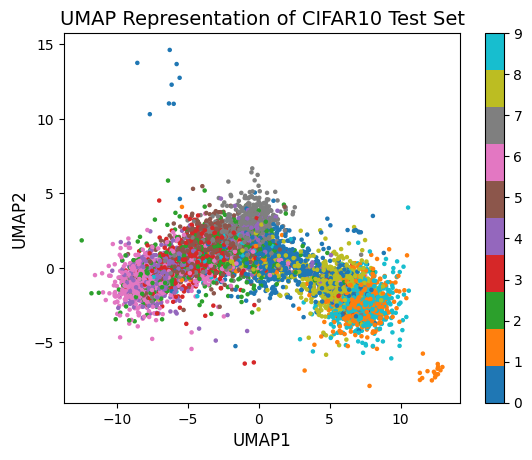

In [ ]:
# Plotting the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=class_labels, cmap='tab10', s=5)
plt.title('UMAP Representation of CIFAR10 Test Set', fontsize=14)
plt.xlabel("UMAP1", fontsize=12)
plt.ylabel("UMAP2", fontsize=12)
plt.colorbar()  # Add a color bar to show the correspondence to class labels
plt.show()

In [ ]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=53e45602da71440ded566acddc1a9b8fab21af1347acf2a05fa49c21d92203b1
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import umap.umap_ as umap



In [ ]:
# Extract class labels from CIFAR10
class_labels = []
for _, labels in testloader:
    class_labels.extend(labels.tolist())

# Convert to a NumPy array for easier handling
import numpy as np
class_labels = np.array(class_labels)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'Embedding of the training set by UMAP')

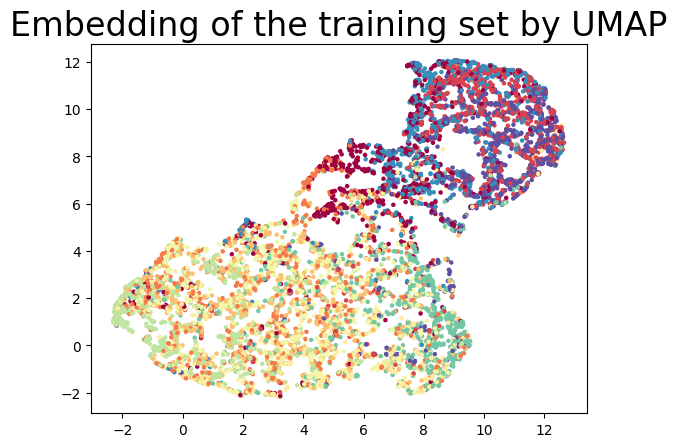

In [ ]:
trans = umap.UMAP(n_neighbors=15, min_dist=0.01,random_state=42).fit(representations)
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=class_labels, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


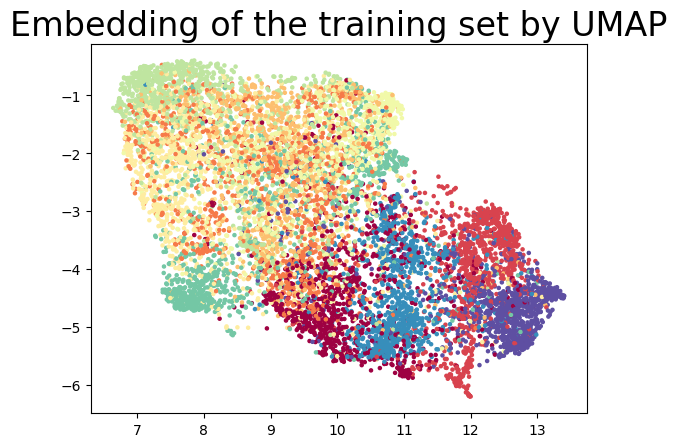

In [ ]:
trans = umap.UMAP(n_neighbors=50, min_dist=0.01,random_state=42).fit(representations)
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=class_labels, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);